In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import math
import random
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.preprocessing import StandardScaler, scale
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV


## Ridge Regression and the Lasso

In [2]:
Hitters = pd.read_csv('Hitters.csv')

In [3]:
# clean the data a bit to remove NAs
print(Hitters['Salary'].isnull().sum()) # number of NAs in Salary column'

Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
print(Hitters.shape)
print(Hitters['Salary'].isnull().sum())

59
(263, 20)
0


In [4]:
# feature engineering to prepare for the model training
y = Hitters.Salary
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']]).astype('int')
#print(dummies.head())
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1)
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=46,test_size = 0.3)

In [8]:
# next, we will generate a few canadidates regularization strength(in sklearn, the keyword is alphas)
alphas = 10**np.linspace(10,-2,100)

In [12]:
# associated with each value of alpha is a vector of ridge regression coefficients,
# stored in a matrix that can be accessed by coeffs,
# 19 is the dimension of the features + (intercept needs to call separately) 
# 100 is the len of the alphas based on above array. The result is a numpy series with len 100 and len(coffes[0]) is 19.
# In this specific implementation, the default is no intercept.

ridge = Ridge(fit_intercept=True)
ridge_model_output = pd.DataFrame(columns=['alpha', 'coeffs', 'intercepts', 'MSE'])
for i in range(len(alphas)):
    a = alphas[i]
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    ridge_model_output.at[i, 'alpha'] = a
    ridge_model_output.at[i, 'coeffs'] = ridge.coef_
    ridge_model_output.at[i, 'intercepts'] = ridge.intercept_
    ridge_model_output.at[i, 'MSE'] = mean_squared_error(y_test, ridge.predict(X_test))



In [13]:
ridge_model_output['MSE'] = pd.to_numeric(ridge_model_output['MSE'])
ridge_model_output.loc[ridge_model_output['MSE'].idxmin()]

alpha                                             756463.327555
coeffs        [0.5125323863728214, 0.31174204393242544, 0.08...
intercepts                                           -60.497512
MSE                                               176886.885438
Name: 34, dtype: object

In [14]:
#printing few details about coeffs and intercepts:
print(len(coeffs))
print(len(coeffs[0]))
print(len(intercepts))
print(intercepts[0])

NameError: name 'coeffs' is not defined

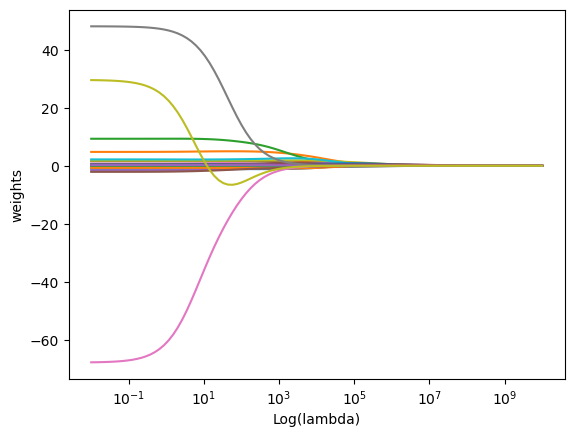

In [57]:
# as design, as alphas get bigger, magnitude of coefficients turn to be closer to zero.
# one thing to remember is that the decay is quite smooth
ax = plt.gca()
ax.plot(alphas, coeffs)
"""
Typically, we scale the alpha(lambda is the notation used in theories) in log scale.
Try to plot it without.
"""
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('Log(lambda)')
plt.ylabel('weights')
plt.show()

## Ridge regression with cross validation

In [58]:
# to select best alpha, we will use cross validation.
# as standard, we will report test set performance as the final performance metric
# https://scikit-learn.org/stable/modules/model_evaluation.html 

ridgecv =  RidgeCV(alphas=(0.1, 0.2, 1.0, 10.0,15, 20, 25), scoring='neg_mean_squared_error', cv = 5)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

25.0

In [59]:
# produce the mean squred error of the selected alpha on test dataset
ridge_best = Ridge(alpha=ridgecv.alpha_)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test))

182299.6038445687

In [60]:
# we can exame the values of the coefficients
"""
If we exam the values of the coefficients, most of them are tiny, but none of them is zero.
This is a diff between ridge and lasso. Ridge shrinks the coefficients proportionally.
"""
pd.Series(ridge_best.coef_, index=X.columns)

AtBat          -1.099623
Hits            4.967781
HmRun           8.972590
Runs            0.100004
RBI            -1.353654
Walks           1.484142
Years           0.859402
CAtBat         -0.440210
CHits           1.733507
CHmRun          2.176891
CRuns           0.563151
CRBI           -0.745306
CWalks          0.029242
PutOuts         0.349821
Assists         0.231266
Errors         -1.570039
League_A      -24.584968
Division_E     29.660424
NewLeague_A    -5.021880
dtype: float64

## LASSO Regression 

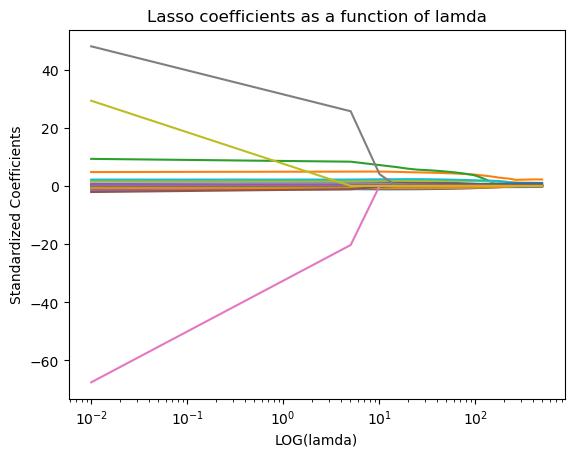

In [61]:
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('LOG(lamda)')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of lamda');

### LASSO with CV

In [62]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

X_numerical = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
list_numerical = X_numerical.columns
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5,max_iter=10000,random_state=0) #if alpha not set, it will be chosen automatically within the algorithm

# Fit model
model.fit(X_train, y_train)
#Show best value of penalization chosen by cross validation:
print("test MSE is", mean_squared_error(y_test, model.predict(X_test)))
print("Model coefficients of the best model are", model.coef_)
print("Alpha value for best model is", model.alpha_)

test MSE is 184215.83109666055
Model coefficients of the best model are [  0.         108.51209503  38.82707665   0.54667333   0.
   0.          -0.           0.           0.          19.03217851
 182.31572158   0.           0.          96.54202981  -0.
  -0.          -0.           0.76750142  -0.        ]
Alpha value for best model is 16.401811334245043


In [63]:
print(list(zip(model.coef_, X)))

[(0.0, 'AtBat'), (108.51209503412947, 'Hits'), (38.82707664829132, 'HmRun'), (0.5466733295883653, 'Runs'), (0.0, 'RBI'), (0.0, 'Walks'), (-0.0, 'Years'), (0.0, 'CAtBat'), (0.0, 'CHits'), (19.03217850886612, 'CHmRun'), (182.31572158052452, 'CRuns'), (0.0, 'CRBI'), (0.0, 'CWalks'), (96.54202980529422, 'PutOuts'), (-0.0, 'Assists'), (-0.0, 'Errors'), (-0.0, 'League_A'), (0.7675014181292427, 'Division_E'), (-0.0, 'NewLeague_A')]


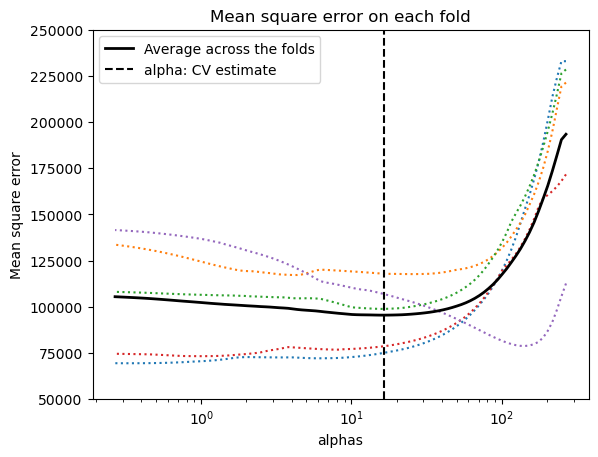

In [65]:
#Lasso path: plot results of cross-validation with mean squared erros 
#(for more information about the plot visit the scikit-learn documentation for lassoCV)

# Make a plot with log scaling on the x-axis.
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax);